In [150]:
# importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# configuring matplotlib and seaborn 
%matplotlib inline
sns.set_theme(style='darkgrid')
plt.style.use('seaborn')

In [2]:
# loading the data from .csv file
original_data = pd.read_csv('cookie_cats.csv')

# making a copy of data to always have an access to the original data
data = original_data.copy()

# Data Cleaning

In [3]:
# first look at the data
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# rows & columns
data.shape

(90189, 5)

In [5]:
# data types information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Cool! Looks like all the data types are okay for its purpose and shouldn't contain null values. 

In [6]:
# it would be beneficial for further use to replace True and False with 1s and 0s, correspondingly
data.replace({False: 0, True: 1}, inplace=True)

In [7]:
# .describe() the data
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


1) 'userid' is numerical, but ordinal data type, there's no sense in its summary statistics

2) 'sum_gamerounds' shows a couple of interesting things:
    
    1) with median of 16, the 3d quartile value of 51 and mean of 51, std is 195. This is quite suspicious. The reason fot this is obviously max value of 49854. This is an outlier
    
    2) there's a number of people who had installed the game, but never played the game with minimum of 1
    
3) 'retention_1': as these values consist of 0s and 1s, we cam make the fist few inferences about retention based on the mean without consideration of Control and Test groups. As retention is relation of people who played the game to all people who installed the game:
        
    the retention rate overall on the 1st day is 0.445210 ~ 44.52%
    
    the retention rate overall on the 7th day is 0.186065 ~ 18.6%

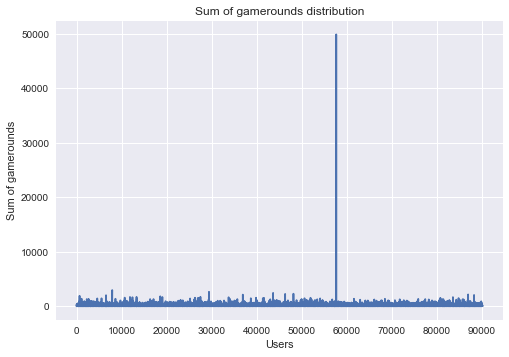

In [8]:
# visualizing data
plt.plot(data['sum_gamerounds'])
plt.title('Sum of gamerounds distribution')
plt.xlabel('Users')
plt.ylabel('Sum of gamerounds')
plt.xticks(np.arange(0, data['userid'].count(), step=10000))
plt.show()

In [9]:
# there's one outlier that may be deleted not to scew the results
# probably it appeared because of technical issues on server or bot
data[data['sum_gamerounds'] == 49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1


In [10]:
# drop outlier
data = data.drop(57702, axis=0)

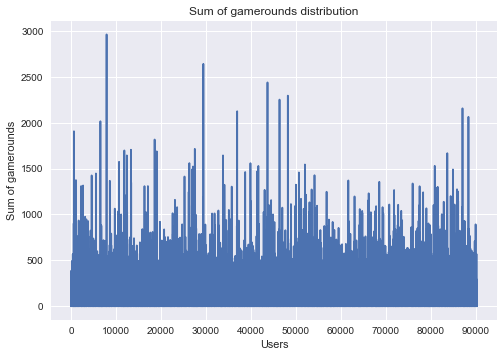

In [11]:
# visualize without outlier 

plt.plot(data['sum_gamerounds'])
plt.title('Sum of gamerounds distribution')
plt.xlabel('Users')
plt.ylabel('Sum of gamerounds')
plt.xticks(np.arange(0, data['userid'].count(), step=10000))
plt.show()

In [12]:
# fortunately, seems like all the users in userid column are unqiue and corresponding rows represent unique information
all_users = data['userid'].nunique()
print('All users who installed the game: {}'.format(all_users))

All users who installed the game: 90188


In [13]:
# sanity check for null values in the dataset
data.isnull().value_counts()

userid  version  sum_gamerounds  retention_1  retention_7
False   False    False           False        False          90188
dtype: int64

# Exploratory Data Analysis

In [14]:
# no Null values!
# but there are datapoints of users who had installed but never played the game
no_play = data[data['sum_gamerounds'] == 0]['userid'].count()
print('Users who did not play: {}. Percentagewise: {}%'.format(no_play, round(no_play/all_users * 100, 2)))

Users who did not play: 3994. Percentagewise: 4.43%


In [68]:
# let's explore distribution of people who played on different days in Control and Test groups
# number of people played on the 1st and 7th days
data[['retention_1', 'version']].groupby(['version', 'retention_1'])['retention_1'].count()

version  retention_1
gate_30  0              24665
         1              20034
gate_40  0              25370
         1              20119
Name: retention_1, dtype: int64

In [84]:
data[['retention_7', 'version']].groupby(['version', 'retention_7'])['retention_7'].count()

version  retention_7
gate_30  0              36198
         1               8501
gate_40  0              37210
         1               8279
Name: retention_7, dtype: int64

In [79]:
# function to display how many users played

def player_distribution(dataframe, version, retention):
    
    ver = "'gate_{}'".format(version)
    ret = "retention_{}".format(retention)
    
    viz_frame = dataframe.query("version == {}".format(ver)).groupby(ret)['userid'].count().reset_index()
    plot = sns.barplot(data=viz_frame, x='{}'.format(ret), y='userid', hue='{}'.format(ret)) 
    if version == 30:
        plt.xlabel('Retention on day {}, Control group'.format(retention))
    else:
        plt.xlabel('Retention on day {}, Test group'.format(retention))
    plt.legend(title='Retention', loc='upper right', labels=['Not retained', 'Retained'], labelcolor=['blue', 'green'])
    
    print(dataframe.query("version == {}".format(ver)).groupby(ret)['userid'].count())

retention_1
0    24665
1    20034
Name: userid, dtype: int64


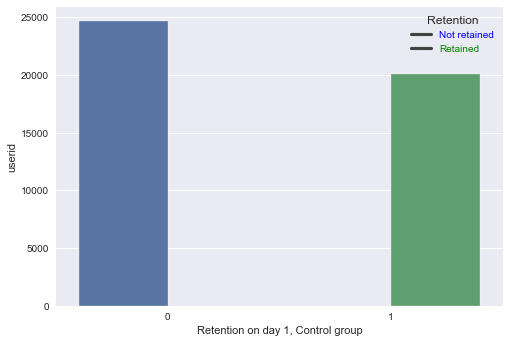

In [80]:
player_distribution(data, 30, 1)

retention_1
0    25370
1    20119
Name: userid, dtype: int64


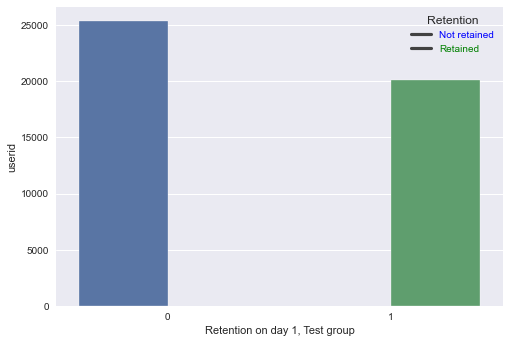

In [81]:
player_distribution(data, 40, 1)

retention_7
0    36198
1     8501
Name: userid, dtype: int64


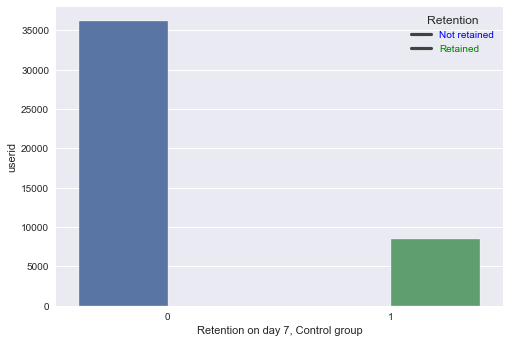

In [82]:
player_distribution(data, 30, 7)

retention_7
0    37210
1     8279
Name: userid, dtype: int64


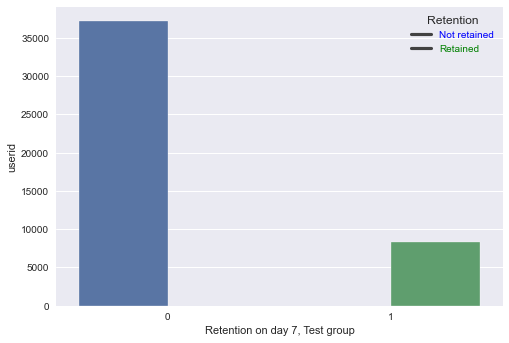

In [83]:
player_distribution(data, 40, 7)

Text(0, 0.5, 'Sum of gamerounds by user')

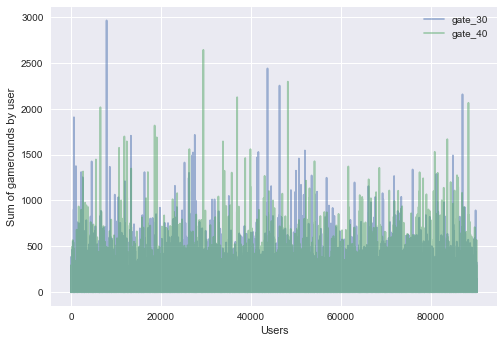

In [87]:
# visualizing distribution of sum_gamerounds between groups
data.groupby('version')['sum_gamerounds'].plot(alpha=0.5, legend=True)
plt.xlabel('Users')
plt.ylabel('Sum of gamerounds by user')

In [127]:
# statistically describe this data between groups
data.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44699.0,51.342111,102.057598,0.0,5.0,17.0,50.0,2961.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In [48]:
# 3d quartile of 75% of this data tells that 75% quartile of people play up to 50 or 52 round depending on the group
# but as std is equal to 102 or 103 round, it's meaningful to look at how people play up to 200th round

2961


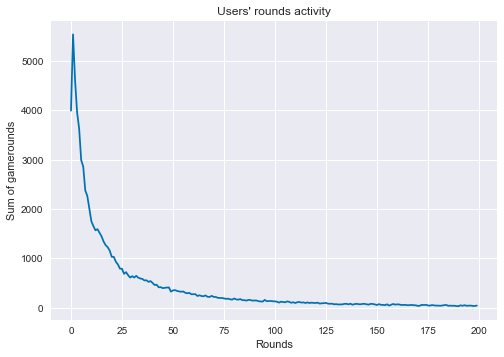

In [146]:
# visualize how users play the game overall
gr = data.groupby('sum_gamerounds').count().reset_index()
sns.lineplot(x='sum_gamerounds', y='userid', data=gr.head(200))
plt.title("Users' rounds activity")
plt.xlabel('Rounds')
plt.ylabel('Sum of gamerounds')

Text(0, 0.5, 'Sum of gamerounds')

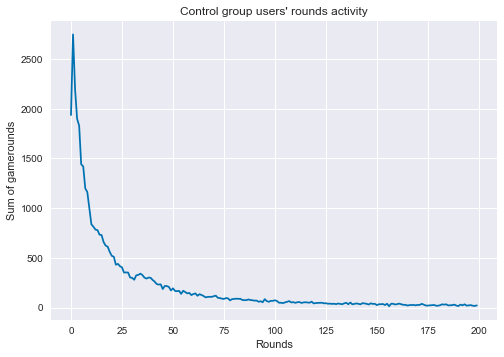

In [149]:
# visualize how users play the game at Control group
v_30 = data.query('version == "gate_30"').groupby('sum_gamerounds').count()
sns.lineplot(x='sum_gamerounds', y='userid', data=v_30.head(200))
plt.title("Control group users' rounds activity")
plt.xlabel('Rounds')
plt.ylabel('Sum of gamerounds')

Text(0, 0.5, 'Sum of gamerounds')

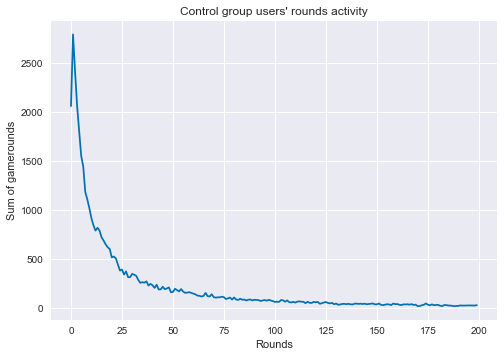

In [144]:
v_40 = data.query('version == "gate_40"').groupby('sum_gamerounds').count()
sns.lineplot(x='sum_gamerounds', y='userid', data=v_40.head(200))
plt.title("Control group users' rounds activity")
plt.xlabel('Rounds')
plt.ylabel('Sum of gamerounds')

## Exploration block for users who did not play neither 1st nor 7th days

Turned out there is data for people who played in the days except 1st and 7th. 
It's possible to say that users who didn't play on the 1st and 7th but played the other days are also retained in both groups. But it's impossible to measure retention rates in this case as it's unknown on what day these users played and what number of people didn't. So I just consider this information as guardial and look at it for general data comprehension

In [104]:
print("Number of users who didn't play on the 1st and 7th days: ")
data.query('retention_1 == 0 and retention_7 == 0')['userid'].count()

Number of users who didn't play on the 1st and 7th days: 


46437

In [100]:
data.query('retention_1 == 0 and retention_7 == 0').groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,22840.0,11.819746,21.642643,0.0,2.0,6.0,14.0,981.0
gate_40,23597.0,11.913294,20.901020,0.0,2.0,6.0,14.0,547.0


Text(0, 0.5, 'Sum of gamerounds')

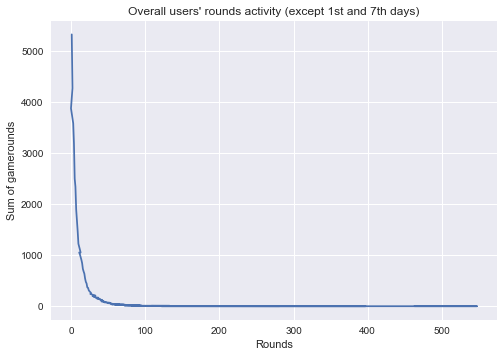

In [105]:
data.query('retention_1 == 0 and retention_7 == 0')['sum_gamerounds'].value_counts().head(200).plot()
plt.title("Overall users' rounds activity (except 1st and 7th days)")
plt.xlabel('Rounds')
plt.ylabel('Sum of gamerounds')

Text(0, 0.5, 'Sum of gamerounds')

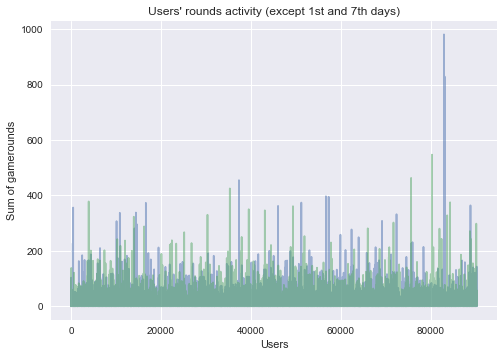

In [102]:
# visualize this data
data.query('retention_1 == 0 and retention_7 == 0').groupby('version')['sum_gamerounds'].plot(alpha=0.5)
plt.title("Users' rounds activity (except 1st and 7th days)")
plt.xlabel('Users')
plt.ylabel('Sum of gamerounds')

# A/B Test Analysis

Now, having explored the data we've seen a decreasing change in retention rates between Control and Test group. The task is to find out if this change occured by random chance or is consistent. In other words, scientifically check if this difference is statistically significant.

In order to find solution for the task, bootstrap analysis is used. Algorithm for boortstap is as follows:

1) Take original sample data (for 'retention_1' or 'retention_7') for exact day considering Control and Test groups

2) Construct a new sample consisting of data points gained grom the original sample. 

    Such a new sample is constructed by randomly extracting values with repetition from the original sample.
 
3) Calculate the difference between Control and Test bootstrapped retention data points

4) Calculate mean (retention) that comes from this difference

5) Save this mean to list data sctructure

6) Repeat n number of times

7) Then, accordingly to the Central Limit Theorem, sample means for any population will be normally distributed approximately around population mean

8) Normal distribution allows us build confidence intervals for established confidence level and thus find a p-value, that's the main estimator of rejecting/accepting Null Hypothesis

p-value is probability that event (sample mean) will have this or more extreme deviation from the population mean. 

In [106]:
# I've defined Bootstrap function to provide calculations for all cases
# to find p_value of the A/B test

def bootstrap(control_data, test_data, n_repeat = 1000, conf_interval = 0.95):
    
    # define the sample size
    boot_len = max([len(control_data), len(test_data)])
    
    # create a list to store bootsrapped mean statistics
    boot_data = list()
    
    # extract samples:
    for i in range(n_repeat):
        sample_control = control_data.sample(boot_len, replace = True).values
        sample_test = test_data.sample(boot_len, replace = True).values
        boot_data.append(np.mean(sample_control) - np.mean(sample_test))
        
    # transform list to DataFrame
    boot_data_df = pd.DataFrame(boot_data)

    # for a two-tailed test p-value calculates as 2 * min(P(s ≤ x), P(s ≥ x))
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    
    # the test is two-tailed, defining quants values 0.025 each with 0.95 confidence interval for later vizs
    quant_left = (1 - conf_interval)/2 
    quant_right = 1 - (1 - conf_interval)/2
    quants = boot_data_df.quantile([quant_left, quant_right]) 
    
    # visualize data
      
    _, _, bars = plt.hist(boot_data, bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('seaborn-colorblind')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--', color='red')
    plt.vlines(np.mean(boot_data),ymin=0,ymax=70,linestyle='-', color='blue')
    plt.xlabel('Bootstrapped sample means')
    plt.ylabel('Frequency')
    plt.title('Histogram of bootstrapped sample means')
    plt.show()
    
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}


### 1st day Retention Rate

In [107]:
# Let's look at Retention Overall 
retention_1_overall = data['retention_1']
print('Overall 1st day retention: ', round((retention_1_overall.mean() * 100), 2))

Overall 1st day retention:  44.52


In [110]:
# Let's look at Retention Rate between Control and Test groups
# and extracting Series data for Bootstrap analysis

# Control group
retention_1_30 = data.query('version == "gate_30"')['retention_1']
print('1st day Retention Rate in the Control group: {}%'.format(round((retention_1_30.mean() * 100), 2)))

# Test group
retention_1_40 = data.query('version == "gate_40"')['retention_1']
print('1st day Retention Rate in the Test group: {}%'.format(round((retention_1_40.mean() * 100), 2)))

1st day Retention Rate in the Control group: 44.82%
1st day Retention Rate in the Test group: 44.23%


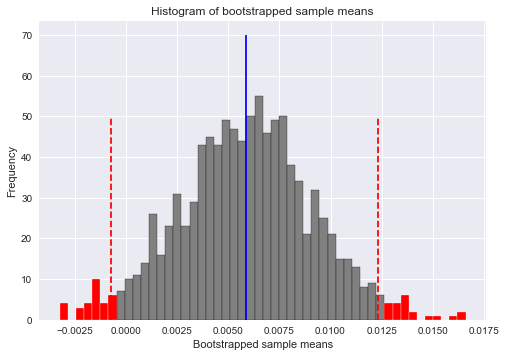

Retention day 1 p-value:  0.07298773884015299


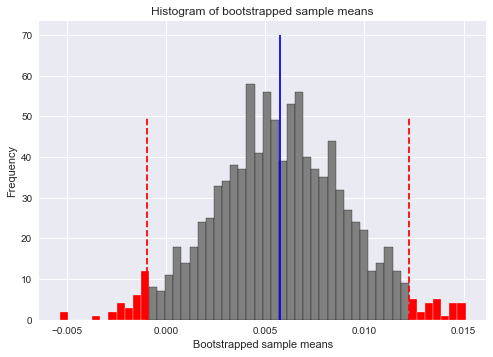

Retention day 1 p-value:  0.08791695435273511


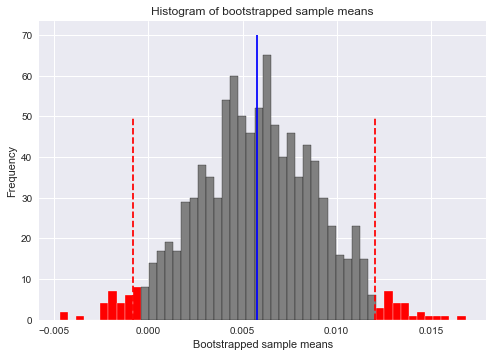

Retention day 1 p-value:  0.07843580810319294


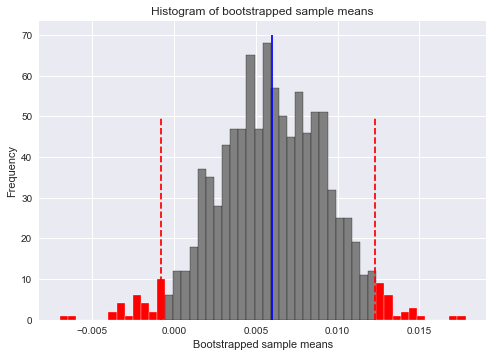

Retention day 1 p-value:  0.07686052790798016


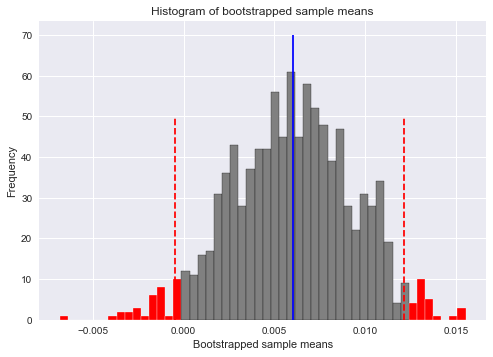

Retention day 1 p-value:  0.07273190912315763


In [145]:
for i in range(5):
    boot_data_1 = bootstrap(retention_1_30, retention_1_40)
    print('Retention day 1 p-value: ', boot_data_1['p_value'])

### 7th day Retention Rate

In [114]:
# Overall Retention Rate on 7th day
retention_7_overall = data['retention_7']

print('Overall 7th day retention: ', round((retention_7_overall.mean() * 100), 2))

# Let's look at Retention Rate between Control and Test groups
# and extracting data for Bootstrap analysis

# Control group
retention_7_30 = data.query('version == "gate_30"')['retention_7']
print('1st day Retention Rate in the Control group: {}%'.format(round((retention_7_30.mean() * 100), 2)))

# Test group
retention_7_40 = data.query('version == "gate_40"')['retention_7']
print('1st day Retention Rate in the Test group: {}%'.format(round((retention_7_40.mean() * 100), 2)))

Overall 7th day retention:  18.61
1st day Retention Rate in the Control group: 19.02%
1st day Retention Rate in the Test group: 18.2%


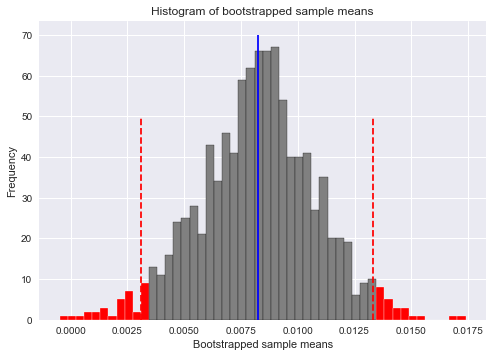

Retention day 7 p-value:  0.001298572156605574
Retention Rate day 7 p-value:  0.13


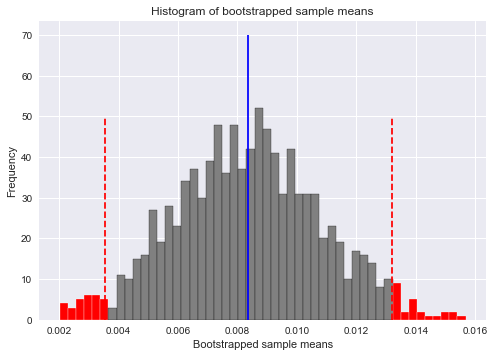

Retention day 7 p-value:  0.0006538247102630222
Retention Rate day 7 p-value:  0.07


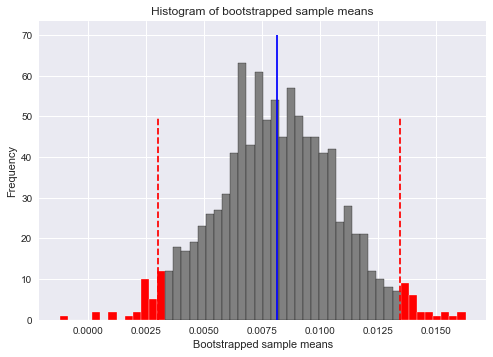

Retention day 7 p-value:  0.0018746308367010968
Retention Rate day 7 p-value:  0.19


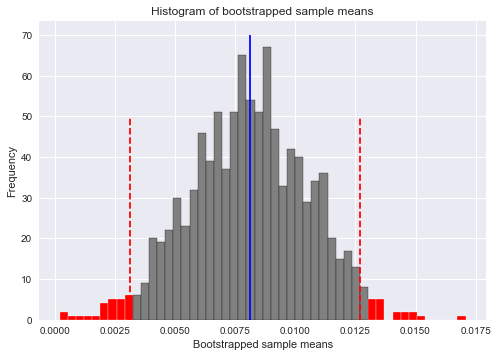

Retention day 7 p-value:  0.0010437920759097524
Retention Rate day 7 p-value:  0.1


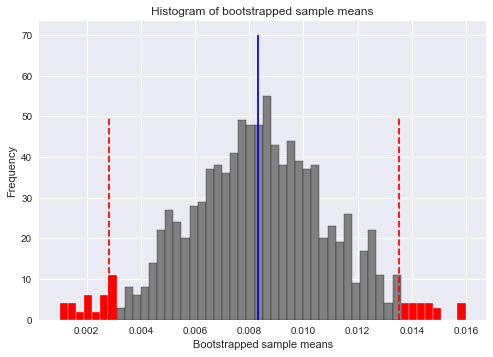

Retention day 7 p-value:  0.001689324598602848
Retention Rate day 7 p-value:  0.17


In [115]:
for i in range(5):
    boot_data_7 = bootstrap(retention_7_30, retention_7_40)
    print('Retention day 7 p-value: ', boot_data_7['p_value'])
    print('Retention Rate day 7 p-value: ', round((boot_data_7['p_value'] * 100), 2))

# Conclusions

Returning to the business problem and objective of the research we had, let's make a data-driven inferences and desicions. 

As a reminder, the Null Hypothesis states that encountering the gate at round 40 will not have statistically significant changes and the Alternative one states the opposit:

H0: Encountering the gate at round 40 will not change Retention Rate

H1: Encountering the gate at round 40 will change Retention Rate

On the EDA stage we've seen that encountering the gate at round 40 even decreases retention rate on 1st and 7th days and we needed to check if this decrease in retention happened due to random chance or is a consistent user behaviour.

Talking about the 1st day, we've obtained p-value that is higher than established threshold of 0.05. So, the Null Hypothesis is true and we can't reject it. The result of the p-value higher than the threshold tells us that there's no difference in Retention rate change between Control and Test groups. But in fact, there's a little change, but it's not statistically significant and occured by random chance.  

So, depending on the results of the 1st day retention, it's better not to move the gate to round 40. 

Talking about the 7th day, we've seen that p-value is less than 0.5 that allows us to reject the Null Hypothesis and accept the Alternative one. But the main point here is that we've also seen that retention rate on this day decreases and there's a difference in % with n active users this day. So, p-value < 0.05 tells us that moving the gate to round 40 really changes retention rate, but in this case the retention is decreased. 

So, obvoisuly, there's no point to move this gate as we don't want retention to decrease. 

In conclusion, insights gained on the basis of statistical analysis demonstrate that moving the gate to round 40 is a bad idea in terms of increasing Retention. 

In order to increase Retention rate we need to continue user research and its behavioural patterns seeking for other action drivers; and then build hypothesis and test them to increase user retention. 